## Fine-Tune a Model: Description: Load a pre-trained LSTM-based NMT model and use it to translate a sentence from one language to another. Description: GUI is not necessary. 

Brief Introduction: Neural machine translation (NMT) uses Deep learning (DL) to translate text from one language to another. It is a powerful state-of-art language translation. In this task, a LSTM-based NMT model is built to translate the text from one to another language. Data Source: 'Tab-delimited Bilingual Sentence Pairs' (English to French) from ManyThings.org

## Load Data

In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Dell\Desktop\NULL_CLASS\Internship\Q2\fra-eng\en-fr.txt", names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,en,fr
0,You're very clever.,Vous êtes fort ingénieuse.
1,Are there kids?,Y a-t-il des enfants ?
2,Come in.,Entrez !
3,Where's Boston?,Où est Boston ?
4,You see what I mean?,Vous voyez ce que je veux dire ?


Note: Above-mentioned dataset (in Data Source) is loaded into a Pandas dataframe. Rows have been reindexed.

## Data Preprocessing
Process: By converting characters to lowercase, removing punctuation marks, and replacing unicode characters with their ASCII equivalents:

In [3]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_text(row))
df.head()

,en,fr
0,youre very clever,vous etes fort ingenieuse
1,are there kids,y atil des enfants
2,come in,entrez
3,wheres boston,ou est boston
4,you see what i mean,vous voyez ce que je veux dire


## Evaluating the maximum length of both English and French phrases. 
Significance: This step will determine the lengths of the sequences that will be the input to and output from the model.

In [5]:
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')

Max phrase length (English): 7
Max phrase length (French): 14


## Fitting Tokenizer to the phrases and generating padded sequences

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=en_max_len, padding='post')

fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=fr_max_len, padding='post')

## Determining vocabulary length

In [9]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 6033
Vocabulary size (French): 12195


## Adding layers
Brief description:
* Embedding layer followed by an LSTM layer: To encode English phrases input to the model.
* RepeatVector layer: To reshape the output from the first LSTM layer that acts as an input to the second LSTM layer.
* Second LSTM layer: To decode the phrases into their French equivalents (as the task is to translate English to French). 
* Softmax classification layer: It is the final layer that gives probabilities for each word in the French vocabulary. 
* TimeDistributed wrapper: To ensures that the built model provides a set of probabilities for each token (word) in the output.

Note: Adam optimizer is used in this task.

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, RepeatVector, TimeDistributed, Dropout

np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(Embedding(en_vocab_size, 256, input_shape=(en_max_len,), mask_zero=True))
model.add(LSTM(256))
model.add(RepeatVector(fr_max_len))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary(line_length=100)

C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                      │ (None, 7, 256)                  │         1,544,448 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm (LSTM)                                │ (None, 256)                     │           525,312 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ repeat_vector (RepeatVector)               │ (None, 14, 256)                 │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm_1 (LSTM)                              │ (None, 14, 256)                 │           525,312 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout (Dropout)                          │ (None, 14, 256)                 │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ time_distributed (TimeDistributed)         │ (None, 14, 12195)               │         3,134,115 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 5,729,187 (21.86 MB)

 Trainable params: 5,729,187 (21.86 MB)

 Non-trainable params: 0 (0.00 B)

## Training of the model
Description: Here the dataset is split into 80:20 ratio in the training and test sets.
Total 50 epochs have been considered with batch size set to 50.
Note: If the accuracy fails to improve for five consecutive epochs, the training will be stopped. To implement this, an argument, called 'patience' is set to 5 in 'EarlyStopping' callback. 

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
hist = model.fit(en_x, fr_y, epochs=50, batch_size=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 438s 536ms/step - accuracy: 0.7126 - loss: 2.8795 - val_accuracy: 0.7351 - val_loss: 1.9106
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 296s 370ms/step - accuracy: 0.7380 - loss: 1.8920 - val_accuracy: 0.7502 - val_loss: 1.7795
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 301s 377ms/step - accuracy: 0.7515 - loss: 1.7510 - val_accuracy: 0.7700 - val_loss: 1.6326
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 298s 373ms/step - accuracy: 0.7709 - loss: 1.5899 - val_accuracy: 0.7836 - val_loss: 1.5033
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 298s 373ms/step - accuracy: 0.7831 - loss: 1.4507 - val_accuracy: 0.7917 - val_loss: 1.4097
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 295s 369ms/step - accuracy: 0.7911 - loss: 1.3395 - val_accuracy: 0.7978 - val_loss: 1.3382
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 298s 372ms/step - accuracy: 0.7981 - loss: 1.2426 - val_accuracy: 0.8028 - val_loss: 1.2801
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 319s 399ms/step - accuracy: 0.8039 -

## Training and Validation Accuracy Plot
Description: x-axis- Number of Epochs, y-axis- Accuracy

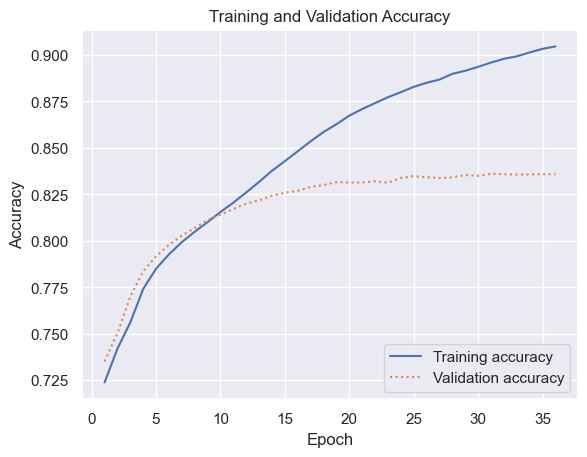

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import History , ModelCheckpoint
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()
plt.show()

## Validating the model
Brief Description: Some reserved phrases are used to validate the model

In [17]:
def translate_text(text, model, en_tokenizer, fr_tokenizer, en_max_len):
    sequence = en_tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=en_max_len, padding='post')
    prediction = model.predict(padded_sequence, verbose=0)[0]
    indexes = [np.argmax(idx) for idx in prediction]
    return fr_tokenizer.sequences_to_texts([indexes])[0]

texts = en[40000:40010].values

for text in texts:
    translated = translate_text(text, model, en_tokenizer, fr_tokenizer, en_max_len)
    print(f'{text} => {translated}')

its fall now => cest suis desormais
im losing => je suis
it was quite funny => ce etait assez amusant
thats not unusual => ce nest pas inhabituel
i think ill do that => je pense que je faire
tom looks different => tom a lair different
its worth a try => ca vaut le defaut
fortune smiled on him => la avec a
lets hit the road => cassonsnous
i love winning => jadore lemporter


## Test the model: Translation from English to French
Note: The model translation task can be tested by putting the sentence (or string of words) within the single inverted comma. Here 'hello world' phrase is shown as an example

In [19]:
translate_text('hello world', model, en_tokenizer, fr_tokenizer, en_max_len)

'salut tout monde'